In [2]:


import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pydicom
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from sklearn.model_selection import KFold

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [8]:
train_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
train_path = ''
train  = pd.read_csv(train_path + 'train.csv')
train.head(5)
# label = pd.read_csv(train_path + 'train_label_coordinates.csv')
# train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')



,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [9]:
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_desc, f'{train_path}train_images')


NameError: name 'train_desc' is not defined

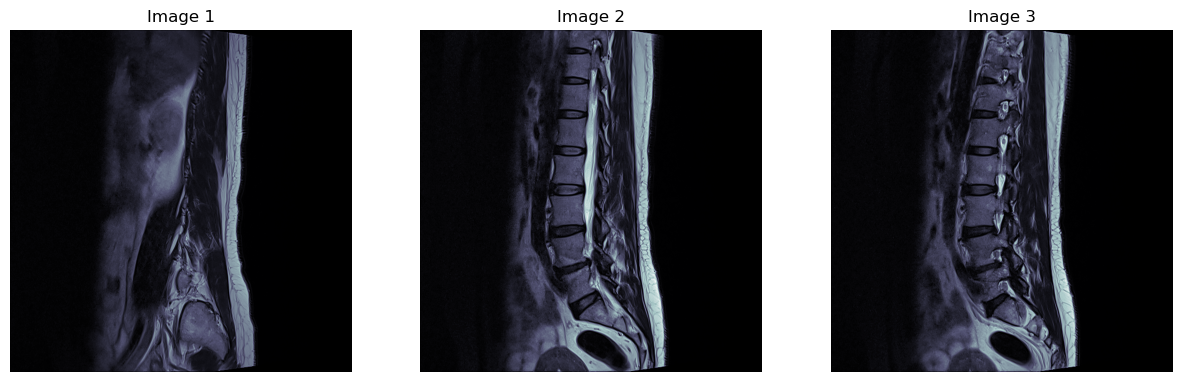

In [ ]:
import pydicom
import matplotlib.pyplot as plt

# Function to open and display DICOM images
def display_dicom_images(image_paths):
    plt.figure(figsize=(15, 5))  # Adjust figure size if needed
    for i, path in enumerate(image_paths[:3]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Display the first three DICOM images
display_dicom_images(train_image_paths)

In [ ]:
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows of the reshaped dataframe
new_train_df.head(5)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [ ]:
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')

In [ ]:
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
# Display the first few rows of the final merged dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [ ]:
final_merged_df[final_merged_df['study_id'] == 100206310].sort_values(['x','y'],ascending = True)
final_merged_df[final_merged_df['series_id'] == 1012284084].sort_values("instance_number")
filtered_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values("instance_number")

# Display the resulting dataframe
filtered_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11430,1013589491,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,2391548363,6,240.770301,411.216131,Sagittal T1
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11429,1013589491,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,2391548363,7,227.194543,355.943404,Sagittal T1
11428,1013589491,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,2391548363,7,222.346058,293.844904,Sagittal T1
11426,1013589491,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,2391548363,7,247.558179,177.458555,Sagittal T1
11427,1013589491,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,2391548363,7,233.012725,234.685828,Sagittal T1
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR


In [ ]:
sorted_final_merged_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values(by=['series_id', 'series_description', 'instance_number'])
sorted_final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11444,1013589491,Right Subarticular Stenosis,L4/L5,Normal/Mild,598943280,13,228.060888,255.755492,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2


In [ ]:
import pandas as pd

# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

# Create the image_path column
final_merged_df['image_path'] = (
    f'{train_path}train_images/' + 
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID. 

# Display the updated dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,train_images/4003253/702807833/8.dcm
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,train_images/4003253/702807833/8.dcm
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,train_images/4003253/702807833/8.dcm
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,train_images/4003253/702807833/8.dcm
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,train_images/4003253/702807833/8.dcm


In [ ]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

train_data = final_merged_df
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        label_map = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}
 

        t = pd.read_csv("train.csv")
        #Fill na with 0
        t = t.fillna(0)
        #study_id/spinal_canal_stenosis_l1_l2

        label = self.dataframe['severity'][index]
        x = self.dataframe['x'][index]
        y = self.dataframe['y'][index]


        series_description = self.dataframe['series_description'][index]
        if series_description == 'Sagittal T2/STIR':
            #Crop x+0.3, y+0.3, x-0.3, y-0.3
            try:
                image_path = self.dataframe['image_path'][index]
                image = load_dicom(image_path)  # Define this function to load your DICOM images

                
                rel_x = x / image.shape[1]
                rel_y = y / image.shape[0]
                image = image[int(y - 0.07 * image.shape[0]):int(y + 0.07 * image.shape[0]), int(x - 0.07 * image.shape[1]):int(x + 0.07 * image.shape[1])]
            except:
                image = np.zeros((256,256))
        # if series_description == 'Axial T2':

    
        col = "spinal_canal_stenosis" + "_" + self.dataframe['level'][index].replace("/","_").lower()
        
        row_t = t[t['study_id'] == self.dataframe['study_id'][index]]
        label = row_t[col].values[0]
        label = label_map[label]   
        image = np.expand_dims(image, axis=-1)

        transforms_val = A.Compose([
            A.Normalize(mean=0.5, std=0.5),
            A.Resize(384, 384)
        ])

        try:
            try:
                image = self.transform(image = image)['image']
            except:
                image = transforms_val(image = image)['image']
            image = np.transpose(image, (2, 0, 1))

            return torch.tensor(image).float(), label
    
        except:
            return torch.zeros((1,384,384)).float(), -100


# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, transform, valid_transform, batch_size=16):
    filtered_df = df[df['series_description'] == series_description]
    filtered_df = filtered_df.fillna(0)
    train_df, val_df = train_test_split(filtered_df, test_size=0.1, random_state=42 , stratify = filtered_df['severity'])
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset1 = CustomDataset(train_df, transform)
    train_dataset2 = CustomDataset(train_df,valid_transform)
    train_dataset = torch.utils.data.ConcatDataset([train_dataset1,train_dataset2])
    val_dataset = CustomDataset(val_df, valid_transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, len(train_df), len(val_df)


# Dictionary mapping labels to indices

import albumentations as A
import torchvision.transforms as transforms

transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1.0),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=1),


    A.HorizontalFlip(p=0.3),
    A.Affine(scale=1.1, shear=10, rotate=10, p=0.8),
    #Pixel Drouput
    A.PixelDropout (p=0.8),
    A.Perspective(scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, always_apply=None, p=0.7),
    A.Morphological(scale=(2, 3), operation='dilation', always_apply=None, p=0.5),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=1.0),
    #VierticalFlip
    A.VerticalFlip(p=0.5),
    A.CoarseDropout(max_holes=4, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, p=0.9),    
    #grey scale 3 channel
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=True),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(384, 384),

    
])

transforms_val = A.Compose([
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=True),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(384, 384)
])

/usr/lib/python3.12/site-packages/pydantic/main.py:193: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [ ]:
# Create dataloaders for each series description
dataloaders = {}
lengths = {}
label_map = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}
train_data['severity'] = train_data['severity'].map(label_map)
trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train_data, 'Sagittal T2/STIR' , transforms_train, transforms_val , batch_size=4)

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)


torch.Size([4, 1, 384, 384]) torch.Size([4])


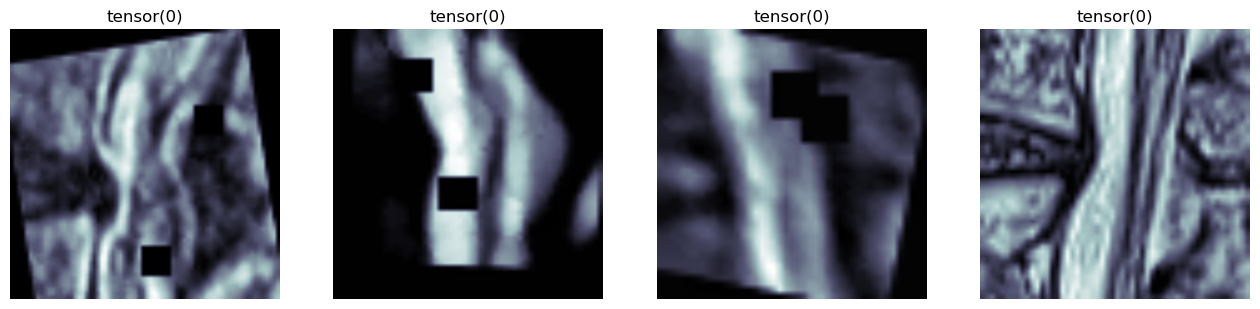

In [ ]:
#Plt sample images
data = next(iter(trainloader_t1))
images, labels = data
print(images.shape, labels.shape)
plt.figure(figsize=(16, 8))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0).squeeze().numpy(), cmap='bone')
    plt.title(labels[i])
    plt.axis('off')




In [ ]:
import timm
timm.list_models('eff*' , pretrained=True)

['efficientformer_l1.snap_dist_in1k',
 'efficientformer_l3.snap_dist_in1k',
 'efficientformer_l7.snap_dist_in1k',
 'efficientformerv2_l.snap_dist_in1k',
 'efficientformerv2_s0.snap_dist_in1k',
 'efficientformerv2_s1.snap_dist_in1k',
 'efficientformerv2_s2.snap_dist_in1k',
 'efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k']

In [ ]:
#Resnet 18
import torch
import torch.nn as nn
model_nmae = 'efficientnetv2_rw_t.ra2_in1k'
model = timm.create_model(model_nmae, pretrained=True , in_chans = 1  , num_classes=3)

# Define the loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = torch.tensor([1.0, 2.0, 4.0])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)

# Define the learning rate scheduler
#LR on Plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)



# Move the model to the GPU
model = model.to(device)
epochs = 100
best_acc = 0.0
from tqdm import tqdm

#Training loop

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    early_stopping = 5
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(dataloaders['Sagittal T1'][0] if phase == 'train' else dataloaders['Sagittal T1'][1]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        if phase == 'train':    
            
            scheduler.step(running_corrects.double() / len(dataloaders['Sagittal T1'][0].dataset))
        
        epoch_loss = running_loss / lengths['Sagittal T1'][0 if phase == 'train' else 1]
        epoch_acc = running_corrects.double() / len(dataloaders['Sagittal T1'][0].dataset if phase == 'train' else dataloaders['Sagittal T1'][1].dataset)
        
        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        #Validation save best model
        if phase == 'val':
            
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                #torch.save(model.state_dict(), 'Sag_PreTrain.pth')
                torch.save(model.state_dict(), 'Sag_PreTrainv2.pth')
                print('Best model saved')
            else:
                early_stopping -= 1
                if early_stopping == 0:
                    break
            print()
    
    print()


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv_stem pretrained weights from 3 to 1 channel(s)
/home/arnesh/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100
----------


100%|██████████| 4387/4387 [12:38<00:00,  5.79it/s]


Train Loss: 0.9879 Acc: 0.8653


100%|██████████| 244/244 [00:28<00:00,  8.68it/s]


Val Loss: 0.3066 Acc: 0.8954
Best model saved


Epoch 2/100
----------


100%|██████████| 4387/4387 [12:18<00:00,  5.94it/s]


Train Loss: 0.6652 Acc: 0.9032


100%|██████████| 244/244 [00:26<00:00,  9.06it/s]


Val Loss: 0.2318 Acc: 0.9272
Best model saved


Epoch 3/100
----------


100%|██████████| 4387/4387 [12:21<00:00,  5.92it/s]


Train Loss: 0.5706 Acc: 0.9153


100%|██████████| 244/244 [00:27<00:00,  8.94it/s]


Val Loss: 0.2290 Acc: 0.9262


Epoch 4/100
----------


100%|██████████| 4387/4387 [12:45<00:00,  5.73it/s]


Train Loss: 0.4928 Acc: 0.9266


100%|██████████| 244/244 [00:30<00:00,  7.91it/s]


Val Loss: 0.2741 Acc: 0.9149


Epoch 5/100
----------


  9%|▉         | 394/4387 [01:10<11:33,  5.76it/s]

In [ ]:
model_nmae = 'efficientnetv2_rw_t.ra2_in1k'
model = timm.create_model(model_nmae, pretrained=True , in_chans = 1  , num_classes=3)

# Define the loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = torch.tensor([1.0, 2.0, 4.0])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)

# Define the learning rate scheduler
#LR on Plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

from tqdm import tqdm

model = model.to(device)
epochs = 100
best_acc = 0.0
# batch_size = 8
# shuffle = True
# dataset = CustomDataset(df, transform=transforms_val)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size] , generator=torch.Generator().manual_seed(42))

batch_size = 8
shuffle = True
dataset = CustomDataset(df, transform=transforms_val)
dataset2 = CustomDataset(df, transform=transforms_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset1 , val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size] , generator=torch.Generator().manual_seed(42))
train_dataset2 , _ = torch.utils.data.random_split(dataset2, [train_size, val_size] , generator=torch.Generator().manual_seed(42))
train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

 
# batch_size = 16
# shuffle = True
# train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
# train_dataset = CustomDataset(train_df, transform=transforms_val)
# val_dataset = CustomDataset(val_df, transform=transforms_val)
# # Create dataloaders

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=shuffle)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

for epoch in range(epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_correct = 0
    with  tqdm(train_loader) as t:
        for i, (img, label) in  enumerate(t):
            img = img.to(device)
            label = label.to(device)
            # Forward pass
            output = model(img)
            loss = criterion(output, label)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            # Calculate the accuracy
            _, preds = torch.max(output, 1)
            train_correct += (preds == label).sum().item()
            t.set_postfix(loss=loss.item())
    # Update the learning rate

    scheduler.step(train_loss)
    # Validate the model
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for i, (img, label) in  (enumerate(val_loader)):
            img = img.to(device)
            label = label.to(device)
            # Forward pass
            output = model(img)
            loss = criterion(output, label)
            val_loss += loss.item()
            # Calculate the accuracy

            _, preds = torch.max(output, 1)
            val_correct += (preds == label).sum().item()

    # Calculate the average loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    val_acc = val_correct / len(val_loader.dataset)
    if val_acc>best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'unet_axial.pt')
        print('EUREKA! Better Model Found!')

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


        
